In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  # natural language processing
nltk.download("stopwords")
nltk.download('vader_lexicon') #Sentiment Analysis Model
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
pd.options.plotting.backend = "plotly"

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Load Tweet dataset
df = pd.read_csv('bitcoin_tweets.csv')
df =df[['text']][0:20000]
print("\n\n-------------ONLY TEXT IN DATAFRAME--------------\n")
print(df.head())


C:\Users\user\AppData\Local\Temp\ipykernel_29192\4286277888.py:2: DtypeWarning: Columns (5,6,7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('bitcoin_tweets.csv')




-------------ONLY TEXT IN DATAFRAME--------------

                                                text
0  Blue Ridge Bank shares halted by NYSE after #b...
1  😎 Today, that's this #Thursday, we will do a "...
2  Guys evening, I have read this article about B...
3  $BTC A big chance in a billion! Price: \487264...
4  This network is secured by 9 508 nodes as of t...


In [3]:
def tweet_to_words(tweet):
    #Convert tweet text into a sequence of words

    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

In [4]:
cleantext=[]
for item in tqdm(df['text']):
    #tqdm displays a progress bar
    words=tweet_to_words(item)
    cleantext+=[words]
df['cleantext']=cleantext
#Now, df has columns: text and cleantext 

def unlist(list):
    #joins the separated words
    words=''
    for item in list:
        words+=item+' '
    return words

100%|██████████| 20000/20000 [03:05<00:00, 108.00it/s]


In [5]:
def compute_vader_scores(df, label):
    sid = SentimentIntensityAnalyzer()
    #computes negative, positive and neutral score for all rows
    #compound score combines pos, neg, neu to get the overall sentiment expressed in the text
    #sid.polarity_scores() returns a dictionary containing the keys: neg, neu, pos, compund
    df["vader_neg"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["neg"])
    df["vader_neu"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["neu"])
    df["vader_pos"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["pos"])
    df["vader_comp"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["compound"])
    df['cleantext2'] = df[label].apply(lambda x: unlist(x))
    return df

In [6]:
df2 = compute_vader_scores(df,'cleantext')
print("AFTER CALCULATING SENTIMENT SCORES\n")
print(df2.head())

AFTER CALCULATING SENTIMENT SCORES

                                                text  \
0  Blue Ridge Bank shares halted by NYSE after #b...   
1  😎 Today, that's this #Thursday, we will do a "...   
2  Guys evening, I have read this article about B...   
3  $BTC A big chance in a billion! Price: \487264...   
4  This network is secured by 9 508 nodes as of t...   

                                           cleantext  vader_neg  vader_neu  \
0  [blue, ridg, bank, share, halt, nyse, bitcoin,...        0.0      0.872   
1  [today, thursday, take, 2, friend, leowandersl...        0.0      0.775   
2  [guy, even, read, articl, btc, would, like, sh...        0.0      0.719   
3  [btc, big, chanc, billion, price, 4872644, 0, ...        0.0      1.000   
4  [network, secur, 9, 508, node, today, soon, bi...        0.2      0.800   

   vader_pos  vader_comp                                         cleantext2  
0      0.128      0.2960  blue ridg bank share halt nyse bitcoin atm ann...  
1 

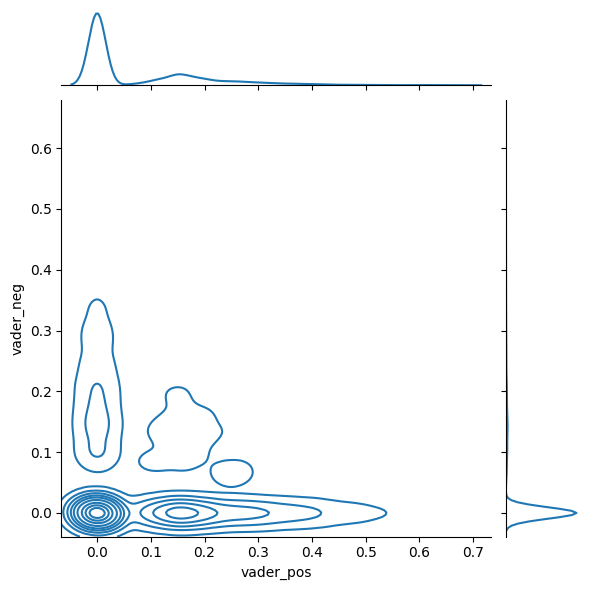

In [7]:
sns.jointplot(data=df2, x='vader_pos', y='vader_neg', kind="kde")

Darker areas indicate higher density.


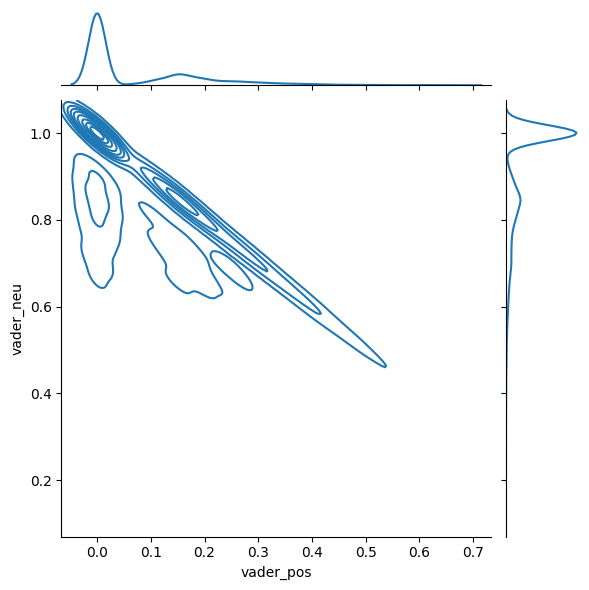

In [8]:
sns.jointplot(data=df2, x='vader_pos', y='vader_neu', kind="kde")

In [9]:
class0=[]
for i in range(len(df2)):
    if df2.loc[i,'vader_neg']>0:
        class0+=["Negative"]
    elif df2.loc[i,'vader_pos']>0:
        class0+=["Positive"]        
    else:
        class0+=["Neutral"]    
df['class']=class0
df['class'].value_counts()
df.head()

,text,cleantext,vader_neg,vader_neu,vader_pos,vader_comp,cleantext2,class
0,Blue Ridge Bank shares halted by NYSE after #b...,"[blue, ridg, bank, share, halt, nyse, bitcoin,...",0.0,0.872,0.128,0.2960,blue ridg bank share halt nyse bitcoin atm ann...,Positive
1,"😎 Today, that's this #Thursday, we will do a ""...","[today, thursday, take, 2, friend, leowandersl...",0.0,0.775,0.225,0.4939,today thursday take 2 friend leowandersleb btc...,Positive
2,"Guys evening, I have read this article about B...","[guy, even, read, articl, btc, would, like, sh...",0.0,0.719,0.281,0.5719,guy even read articl btc would like share http...,Positive
3,$BTC A big chance in a billion! Price: \487264...,"[btc, big, chanc, billion, price, 4872644, 0, ...",0.0,1.000,0.000,0.0000,btc big chanc billion price 4872644 0 2021 02 ...,Neutral
4,This network is secured by 9 508 nodes as of t...,"[network, secur, 9, 508, node, today, soon, bi...",0.2,0.800,0.000,-0.5423,network secur 9 508 node today soon biggest be...,Negative


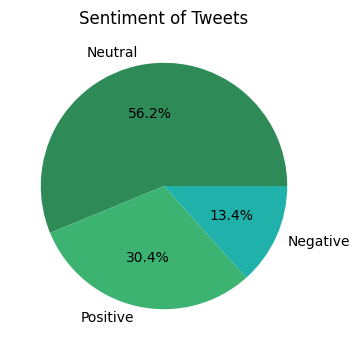

In [10]:
import matplotlib.pyplot as plt

# Calculate class counts
class_counts = df['class'].value_counts()
colors = ['#2E8B57', '#3CB371', '#20B2AA']  

# Create a pie chart using Matplotlib
plt.figure(figsize=(6, 4))  
plt.pie(class_counts, labels=class_counts.index, autopct="%1.1f%%", colors=colors)
plt.title("Sentiment of Tweets")
plt.show()


In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50 #Defines the maximum length of sequences after padding.

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequences of integers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text) 
    #builds a dictionary that maps each unique word in the text data to a unique integer index, 
    #which is used to later convert the text to a sequence of integers
    
    X = tokenizer.texts_to_sequences(text) # Transforms text to a sequence of integers
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['cleantext2'][0])
X, tokenizer = tokenize_pad_sequences(df['cleantext2'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 blue ridg bank share halt nyse bitcoin atm announc http co xaazmajkiv myblueridgebank http co sgbxmkp1si 
After Tokenization & Padding 
 [1399 1804  254  406 3652 2760    3 1149  259    2    1    2    1    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [12]:
y = pd.get_dummies(df['class'])
# making training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# splitting training data to training and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set: ', X_train.shape, y_train.shape)
print('Validation Set: ', X_val.shape, y_val.shape)
print('Test Set: ', X_test.shape, y_test.shape)

Train Set:  (12000, 50) (12000, 3)
Validation Set:  (4000, 50) (4000, 3)
Test Set:  (4000, 50) (4000, 3)


In [13]:
import tensorflow.keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [14]:
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD

In [15]:
vocab_size = 5000
embedding_size = 32
epochs = 10
#learning_rate = 0.1
#decay_rate = learning_rate / epochs
#momentum = 0.8

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dropout, Dense

# Hyperparameters 
learning_rate = 0.001
momentum = 0.9
decay_rate = learning_rate / epochs

# Model building 
model = Sequential()
# initializes a Sequential model, which will be used to build the neural network layer by layer.
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4)) 
model.add(Dense(3, activation='softmax'))

# Optimizer choice 
optimizer = SGD(lr=learning_rate, momentum=momentum)

In [17]:
#Embedding:  converts input integers (in our case, word indices) into dense vectors of fixed size.
#Conv1D: performs 1D convolution across the input.
#MaxPooling1D: performs 1D max pooling operation over temporal data.
#Bidirectional: allows the model to learn from both past and future information.
#LSTM: implements the Long Short-Term Memory (LSTM) unit with 32 units
#Dropout: applies dropout regularization with a dropout rate of 0.4, to prevent overfitting b
#Dense: fully connected layer with 3 output units as there are 3 classes of sentiment
#SGD is the optimization algorithm used to update the weights of the neural network during training.

In [18]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', Precision(), Recall()])
#categorical cross entropy is used for multi-class classification
#metrics specifies the evaluation metrics to be used to monitor the model's performance during training and evaluation

In [19]:
history = model.fit(X_train,y_train,validation_data=(X_val, y_val),batch_size=64,epochs=epochs,verbose=1)

Epoch 1/10
188/188 [==============================] - 15s 31ms/step - loss: 0.9632 - accuracy: 0.5624 - precision: 0.5635 - recall: 0.5079 - val_loss: 0.9524 - val_accuracy: 0.5663 - val_precision: 0.5663 - val_recall: 0.5663
Epoch 2/10
188/188 [==============================] - 4s 21ms/step - loss: 0.9518 - accuracy: 0.5648 - precision: 0.5648 - recall: 0.5627 - val_loss: 0.9497 - val_accuracy: 0.5663 - val_precision: 0.5663 - val_recall: 0.5663
Epoch 3/10
188/188 [==============================] - 4s 21ms/step - loss: 0.9478 - accuracy: 0.5648 - precision: 0.5669 - recall: 0.5612 - val_loss: 0.9444 - val_accuracy: 0.5663 - val_precision: 0.5663 - val_recall: 0.5663
Epoch 4/10
188/188 [==============================] - 4s 21ms/step - loss: 0.9345 - accuracy: 0.5648 - precision: 0.5756 - recall: 0.5525 - val_loss: 0.9232 - val_accuracy: 0.5663 - val_precision: 0.5724 - val_recall: 0.5635
Epoch 5/10
188/188 [==============================] - 4s 21ms/step - loss: 0.8945 - accuracy: 0.580

In [20]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.8580
Precision : 0.8849
Recall    : 0.8345
F1 Score  : 0.8590


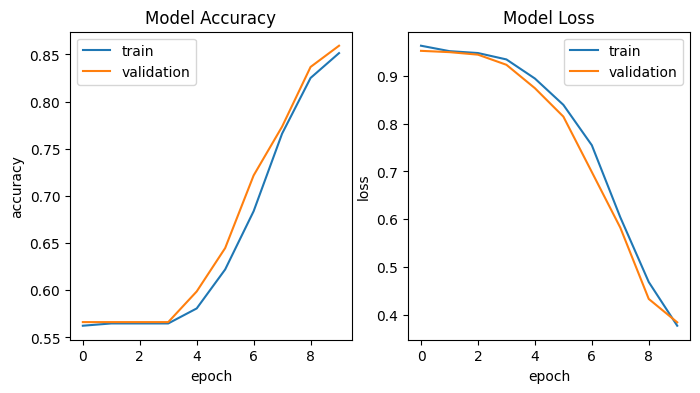

In [21]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1,2, figsize=(8,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)